# SCimilarity cell type annotation
The goal of this tutorial is to familiarize users with SCimilarity's basic celltype annotation functionalities.

- System requirements
   - At least 64GB of RAM
   - SCimilarity package installed
 - Note: these are large files. Ddownloading and processing can take a several minutes.

## 0. Required software and data
Things you need for this demo:

 0. SCimilarity package should already be installed

 1. Models

 2. Data
    - We will use [Adams et al., 2020](https://www.science.org/doi/10.1126/sciadv.aba1983?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed) healthy and IPF lung scRNA-seq data
    - GEO Source: [GSE136831](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE136831) (~2.5GB)


### Download tutorial data and models
Download the tutorial data, a subsample of GSE136831, from [Zenodo](https://zenodo.org):

- [Download tutorial data](https://zenodo.org/record/8242083)
- [Download SCimilarity models](https://zenodo.org/record/8240464)

In [1]:
# Environment settings
import scanpy as sc
sc.set_figure_params(dpi=100)

import warnings
warnings.filterwarnings('ignore')

/home/kuot/miniconda3/envs/gpy/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## 1. Prepare for SCimilarity: Import and normalize data

In [2]:
from scimilarity.utils import lognorm_counts, align_dataset
from scimilarity import CellAnnotation

### Import SCimilarity - Cell annotation object

In [3]:
# If the models haven't been downloaded please uncomment and run the two command below
#!curl -L -o /models/annotation_model_v1.tar.gz https://zenodo.org/record/8240464/files/annotation_model_v1.tar.gz?download=1
#!curl -L -o /models/query_model_v1.tar.gz https://zenodo.org/record/8240464/files/query_model_v1.tar.gz?download=1
#!tar -xzvf /models/annotation_model_v1.tar.gz
#!tar -xzvf /models/query_model_v1.tar.gz

In [4]:
# Instantiate the CellAnnotation object.
# Replace model_path with your local file path.
model_path = '/models/model_v1'
ca = CellAnnotation(model_path=model_path)

### Load scRNA-seq data

In [5]:
# To Download the demo data to the data/ directory uncomment and run the command below
#! curl -L -o /data/GSE136831_subsample.h5ad https://zenodo.org/record/8242083/files/GSE136831_subsample.h5ad?download=1

In [6]:
# Load the tutorial data.
# Replace data_path with your local file path.
data_path = '/data/GSE136831_subsample.h5ad'
adams = sc.read(data_path)

### SCimilarity pre-processing
SCimilarity requires new data to be processed in a specific way that matches how the model was trained. 

#### Match feature space with SCimilarity models 
SCimilarity's gene expression ordering is fixed. New data should be re-orderd to match that. Genes that are not present in the new data will be zero filled to comply to the expected structure. Genes that are not present in SCimilarity's gene ordering will be filtered out. 

Note: SCimilarity was trained with high data dropout to increase robustness to differences in gene lists. 

In [7]:
adams = align_dataset(adams, ca.gene_order)

#### Normalize data consistent with SCimilarity
It is important to match Scimilarity's normalization so that the data matches the lognorm tp10k procedure used during model training.

In [8]:
adams = lognorm_counts(adams)

With these simple steps, the data is now ready for SCimilarity. We are able to filter cells later (even after embedding) because SCimilarity handles each cell indepdendently and can skip highly variable gene selection altogether.

## 2. Compute embeddings
Using the already trained models, SCimilarity can embed your new dataset. 

In [9]:
adams.obsm['X_scimilarity'] = ca.get_embeddings(adams.X)

### Compute visualization of embeddings
#### Use UMAP to visualize SCimilarity embeddings

In [10]:
sc.pp.neighbors(adams, use_rep='X_scimilarity')
sc.tl.umap(adams)

### Visualize author annotations on the SCimilarity embedding
Given that author annotations are derived from a different analysis, seeing author annotations roughly cluster in SCimilarity embedding space gives us confidence in our representation. 

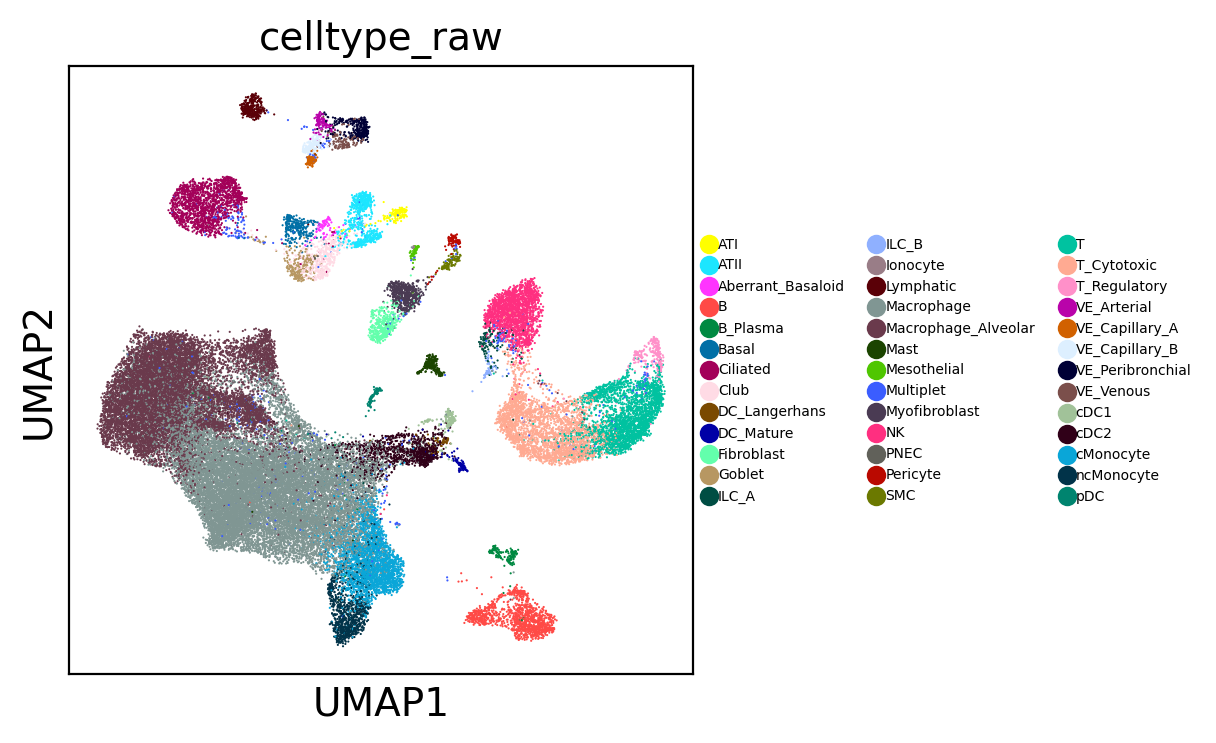

In [11]:
sc.pl.umap(adams, color='celltype_raw', legend_fontsize=5)

Adams et al dataset was not included in the training set, meaning that this is the first time the model has seen this data, yet it is still able to represent the cell types present. 

## 3. Cell type classification

Two methods within the CellAnnotation class:
 1. `annotate_dataset` - automatically computes embeddings
 2. `get_predictions` - more detailed control of annotation

*Description of inputs*
 - X_scimilarity: embeddings from the model, which can be used to generate umaps in lieu of PCA and is in theory general across datasets    

*Description of outputs*
 - predictions: celltype label predictions.
 - nn_idxs: indicies of cells in the SCimilarity reference. 
 - nn_dists: the minimum distance within k=50 nearest neighbors.
 - nn_stats: a dataframe containing useful metrics such as: 
     - hits: the distribution of celltypes in k=50 nearest neighbors.

### Unconstrained annotation
Cells can be classified as any type that is in the SCimilarity reference 

In [12]:
predictions, nn_idxs, nn_dists, nn_stats = ca.get_predictions_kNN(adams.obsm['X_scimilarity'])
adams.obs['predictions_unconstrained'] = predictions.values

Get nearest neighbors finished in: 0.07320477962493896 min


100%|██████████| 50000/50000 [00:20<00:00, 2416.27it/s]


#### Since each cell is classified independently, there is higher classification noise, filtering out low count cells can reduce the noise in visualization



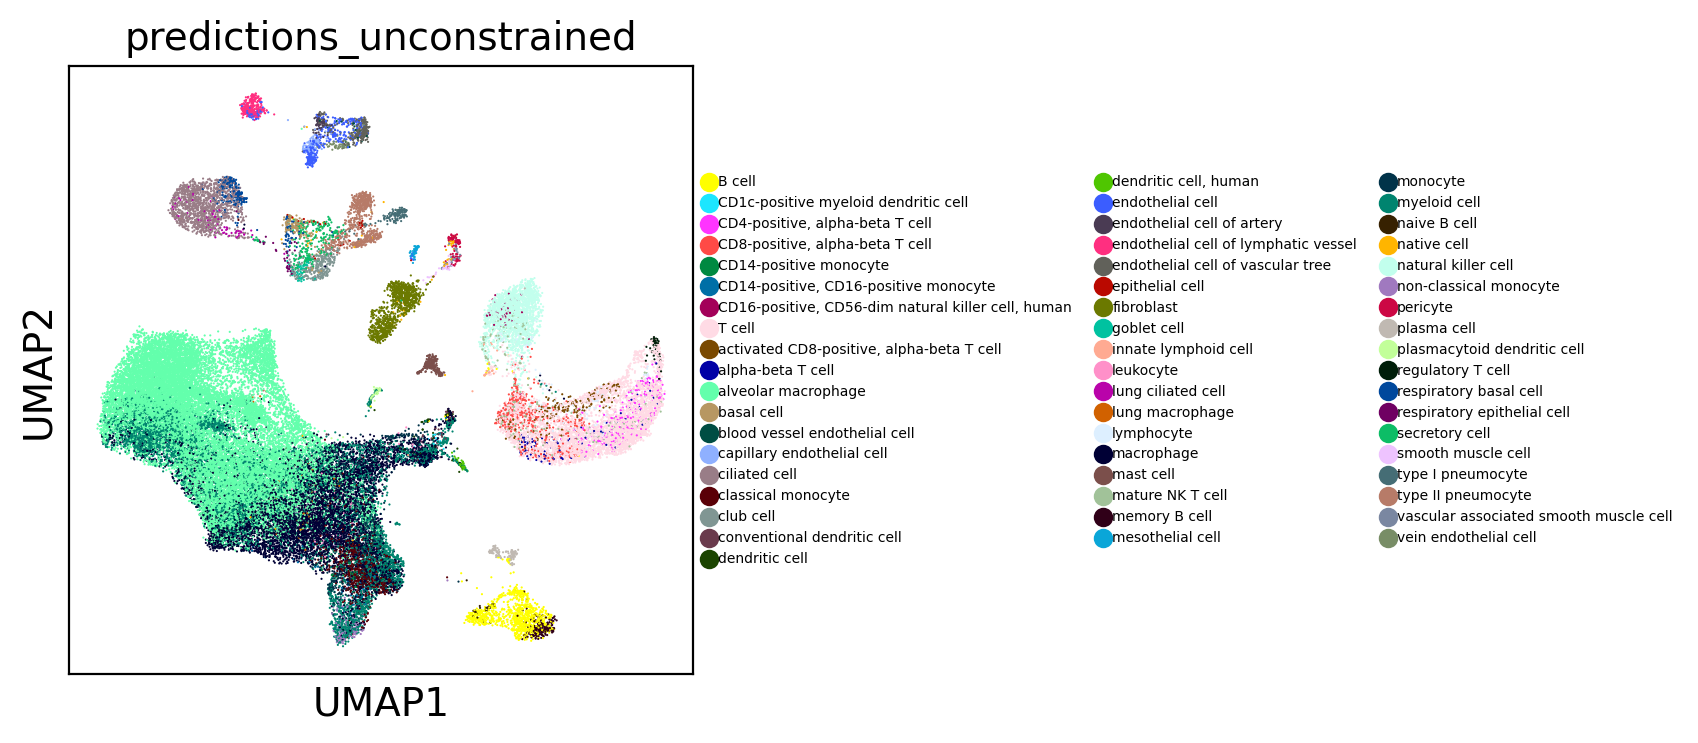

In [13]:
celltype_counts = adams.obs.predictions_unconstrained.value_counts()
well_represented_celltypes = celltype_counts[celltype_counts>20].index

sc.pl.umap(adams[adams.obs.predictions_unconstrained.isin(well_represented_celltypes)], 
           color='predictions_unconstrained', 
           legend_fontsize=5)

### Constrained classification
By classifying against the full reference, we can get redundant cell types, e.g. activated CD8-positive, alpha-beta T cell and CD8-positive, alpha-beta T cell.

Alternatively we can subset the reference to just the cell types we want to classify to. This can lead to less cell type annotation noise.

Note: subsetting can slow classification speeds due kNN optimization for full reference classification.

In [14]:
target_celltypes = ['alveolar macrophage', 'macrophage', 'natural killer cell', 'ciliated cell', 'mature NK T cell',
                    'B cell', 'fibroblast', 'classical monocyte', 'type II pneumocyte', 'endothelial cell of vascular tree',
                    'club cell', 'endothelial cell of lymphatic vessel', 'CD8-positive, alpha-beta T cell',
                    'respiratory basal cell', 'mast cell', 'type I pneumocyte', 'secretory cell', 'CD4-positive, alpha-beta T cell',
                    'lung macrophage', 'plasma cell', 'basal cell', 'non-classical monocyte', 'plasmacytoid dendritic cell',
                    'lung ciliated cell', 'vascular associated smooth muscle cell', 'conventional dendritic cell',
                    'goblet cell', 'smooth muscle cell', 'pericyte', 'regulatory T cell', 'myofibroblast cell',
                    'neuroendocrine cell', 'pulmonary ionocyte']

ca.safelist_celltypes(target_celltypes)

In [15]:
adams = ca.annotate_dataset(adams)

Get nearest neighbors finished in: 0.23504385153452556 min


100%|██████████| 50000/50000 [00:20<00:00, 2452.69it/s]


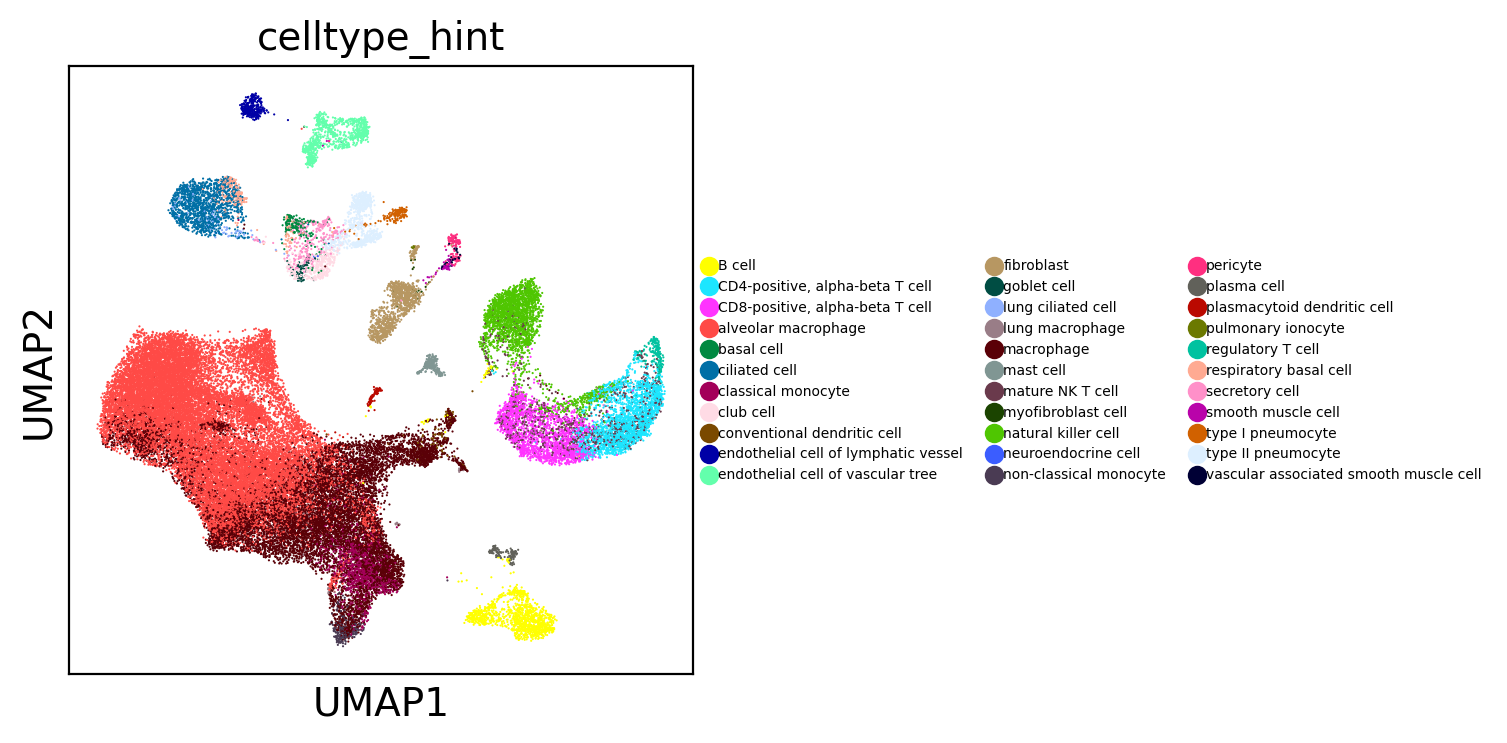

In [16]:
sc.pl.umap(adams, color='celltype_hint', legend_fontsize=5)

### Annotation QC
Cell annotation also computes QC metrics for our annotations. One of which, `min_dist`, represents the minimum distance between a cell in the query dataset and all cells in the training set. The greater `min_dist`, (i.e. the further away from what the model has seen before) the less confidence we have in the model's prediction. 

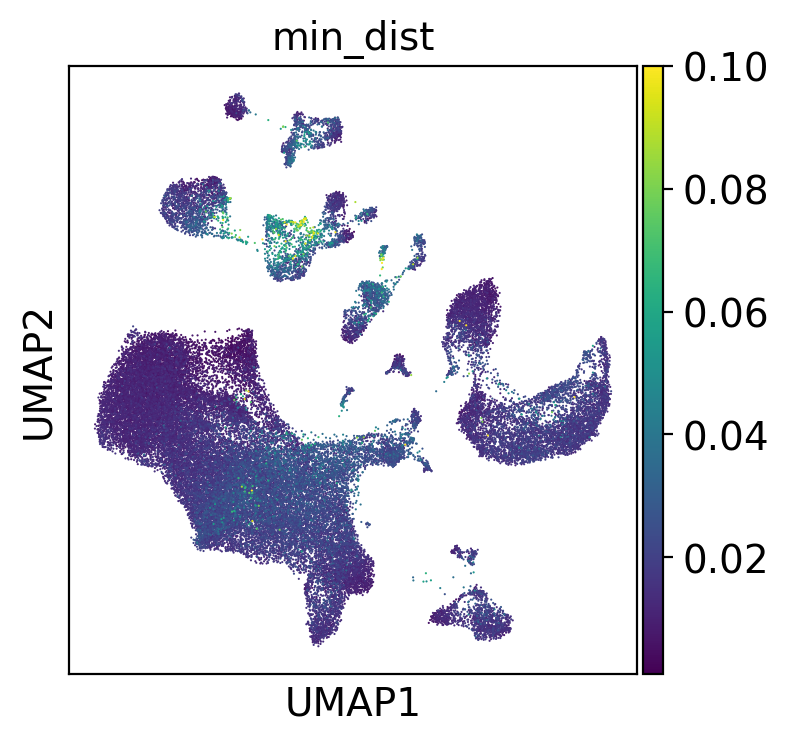

In [17]:
sc.pl.umap(adams, color='min_dist', vmax=.1)

## Conclusion: How to apply to your own datasets
This notebook outlines how to take a dataset and perform cell type annotation.

 - Keep in mind that the datasets that you analyze with SCimilarity should fit the following criteria:
   - Data generated from 10X Chromium machine (models are trained using this data only).
   - Human scRNA-seq data.
   - Normalized from counts with SCimilarity functions or using the same process. Different normalizations will have poor results.